In [6]:
import pandas as pd
import seaborn as sns

In [8]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/javierherrera1996/IntroMachineLearning/refs/heads/main/SegundoCorte/loan_approval_dataset.csv")

In [19]:
df.columns = df.columns.str.strip()
df["loan_status"] = df["loan_status"].str.strip()

In [20]:
avg_income = df["income_annum"].mean()

In [21]:
approved_cibil_avg = df[df["loan_status"] == "Approved"]["cibil_score"].mean()

In [22]:
avg_loan_term = df["loan_term"].mean()

In [23]:
print("Promedio de ingresos anuales:", avg_income)
print("Puntaje CIBIL promedio (aprobados):", approved_cibil_avg)
print("Duración promedio del préstamo:", avg_loan_term)

Promedio de ingresos anuales: 5059123.9166081045
Puntaje CIBIL promedio (aprobados): 703.4619728915662
Duración promedio del préstamo: 10.900445069102835


In [24]:
df.columns = df.columns.str.strip()
df["education"] = df["education"].str.strip()
df["self_employed"] = df["self_employed"].str.strip()

In [25]:
df["education_bin"] = df["education"].map({"Graduate": 1, "Not Graduate": 0})

In [26]:
df["self_employed_bin"] = df["self_employed"].map({"Yes": 1, "No": 0})

In [27]:
df.fillna(df.mean(numeric_only=True), inplace=True)

In [28]:
print(df[["education", "education_bin", "self_employed", "self_employed_bin"]].head())

      education  education_bin self_employed  self_employed_bin
0      Graduate              1            No                  0
1  Not Graduate              0           Yes                  1
2      Graduate              1            No                  0
3      Graduate              1            No                  0
4  Not Graduate              0           Yes                  1


In [29]:
corr_income_loan = df["income_annum"].corr(df["loan_amount"])
corr_cibil_loan = df["cibil_score"].corr(df["loan_amount"])
corr_res_com_assets = df["residential_assets_value"].corr(df["commercial_assets_value"])

In [31]:
print("Correlación entre income_annum y loan_amount:", corr_income_loan)
print("Correlación entre cibil_score y loan_amount:", corr_cibil_loan)
print("Correlación entre residential_assets_value y commercial_assets_value:", corr_res_com_assets)



Correlación entre income_annum y loan_amount: 0.9274699109871487
Correlación entre cibil_score y loan_amount: -0.017034787023534392
Correlación entre residential_assets_value y commercial_assets_value: 0.41478602657549807


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [33]:
df.columns = df.columns.str.strip()
df["loan_status"] = df["loan_status"].str.strip()
df["education"] = df["education"].str.strip()
df["self_employed"] = df["self_employed"].str.strip()

In [34]:
df["education_bin"] = df["education"].map({"Graduate": 1, "Not Graduate": 0})
df["self_employed_bin"] = df["self_employed"].map({"Yes": 1, "No": 0})
df["loan_status_bin"] = df["loan_status"].map({"Approved": 1, "Rejected": 0})

In [35]:
df.fillna(df.mean(numeric_only=True), inplace=True)

In [38]:
features = [
    "no_of_dependents", "income_annum", "loan_amount", "loan_term",
    "cibil_score", "residential_assets_value", "commercial_assets_value",
    "luxury_assets_value", "bank_asset_value", "education_bin", "self_employed_bin"
]
X = df[features]
y = df["loan_status_bin"]

In [39]:
print("Distribución original de clases:\n", y.value_counts())
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("Después de SMOTE:\n", pd.Series(y_balanced).value_counts())

Distribución original de clases:
 loan_status_bin
1    2656
0    1613
Name: count, dtype: int64
Después de SMOTE:
 loan_status_bin
1    2656
0    2656
Name: count, dtype: int64


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [42]:
log_model = LogisticRegression(max_iter=1000)
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)  # limitar profundidad para evitar overfitting

log_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [43]:
log_probs = log_model.predict_proba(X_test)[:, 1]
tree_probs = tree_model.predict_proba(X_test)[:, 1]

log_auc = roc_auc_score(y_test, log_probs)
tree_auc = roc_auc_score(y_test, tree_probs)

print("ROC AUC - Regresión Logística:", log_auc)
print("ROC AUC - Árbol de Decisión:", tree_auc)

ROC AUC - Regresión Logística: 0.859423858199868
ROC AUC - Árbol de Decisión: 0.9957207601026451


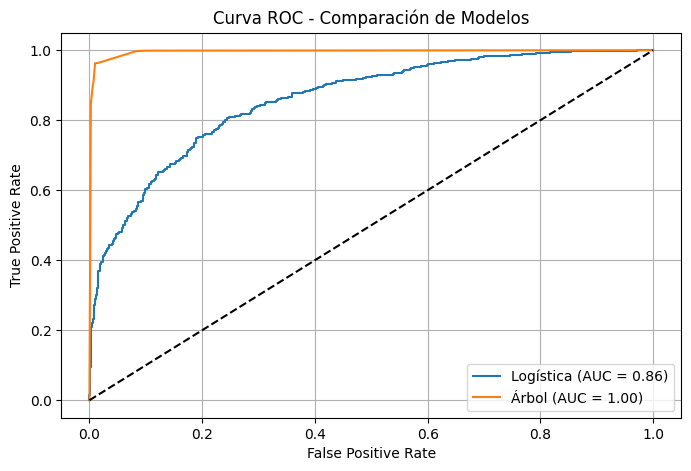

In [45]:
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr_log, tpr_log, label=f"Logística (AUC = {log_auc:.2f})")
plt.plot(fpr_tree, tpr_tree, label=f"Árbol (AUC = {tree_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparación de Modelos")
plt.legend()
plt.grid()
plt.show()

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
log_preds = log_model.predict(X_test)
tree_preds = tree_model.predict(X_test)

In [48]:
print("📊 Regresión Logística:")
print(confusion_matrix(y_test, log_preds))
print(classification_report(y_test, log_preds))

📊 Regresión Logística:
[[565 252]
 [121 656]]
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       817
           1       0.72      0.84      0.78       777

    accuracy                           0.77      1594
   macro avg       0.77      0.77      0.77      1594
weighted avg       0.77      0.77      0.76      1594



In [49]:
print("\n🌳 Árbol de Decisión:")
print(confusion_matrix(y_test, tree_preds))
print(classification_report(y_test, tree_preds))


🌳 Árbol de Decisión:
[[804  13]
 [ 28 749]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       817
           1       0.98      0.96      0.97       777

    accuracy                           0.97      1594
   macro avg       0.97      0.97      0.97      1594
weighted avg       0.97      0.97      0.97      1594

